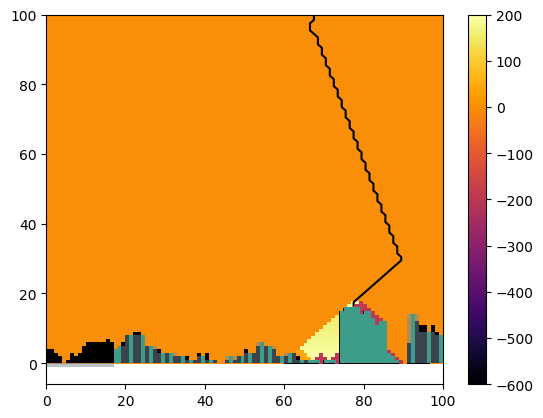

The lander has arrived at x=78 and z=17 in 83 iterations
Measurements made : 47
Safe landing!


In [33]:
using PyPlot
include("structures.jl")
include("fct_obsAndBel.jl")
include("fct_MDP.jl")
include("fct_map.jl")
include("params.jl")
println(" ")

#initialization
MAP_SIZE = 100
#srand(1234)
true_map=build_map(25)
#true_map_old = vcat([1, 2, 3, 3, 3, 4, 5, 6, 6, 5],
#    collect(ceil.(linspace(1,50,(100-38)))),
#    [4, 3, 2, 1, 1, 1, 2, 3, 4, 5, 6, 5, 4, 6, 10, 11, 15, 22, 30, 30, 30, 31, 25, 20, 15, 1,1, 1])

#true_map = collect(linspace(1,50,100))

# Initialize
# Lander is at altitude 100, terrain is set to zero altitude, its bounds are from zero to 50 m high. 
#lander= Lander(50,100)
observation_map = zeros(MAP_SIZE,1)-1 #if no observation, set to -1


# build a belief map with heights and a confidence value
belief_map = zeros(MAP_SIZE,2)
x_path = [lander.x]
z_path = [lander.z]

belief_map=hcat(true_map,ones(100,1))
R_obsmap=zeros(100,100)
U_init=update_utility(belief_map,lander,gamma,R_obsmap)
iteration = 0
U_curr=zeros(100,100)
fig = figure()


while lander.z>(true_map[lander.x]) && iteration<110
    if iteration%obs_lag==0
        # observe
        o = make_observation(true_map, lander)
        observation_map[o.x] = o.h

        # update your belief
        belief_map = update_belief(observation_map, MODEL)
        #belief_map=hcat(true_map,ones(100,1))
        
        #Search incentive
        R_obsmap=zeros(100,100)
        z=lander.z-obs_lag
        if z>1
            for x=max(1,lander.x-obs_lag):min(100,lander.x+obs_lag)
                xobs = [max(1,x-div(z,2)); x; min(x + div(z,2),100)]
                b1=belief_map[xobs[1],2]
                b2=belief_map[xobs[2],2]
                b3=belief_map[xobs[3],2]
                R_obsmap[x,z]=R_newobs*((b1<1)+2*(b2<1)+(b3<1))
            end
        end
        #(maximum(R_obsmap))
        
        U_curr=update_utility(belief_map,lander,gamma,R_obsmap)
        # find flat parts in the belief map (obsolete)
        #flat = find_flat(belief_map)
    end
    # make your decision
    opt_action=choose_action(lander.x,lander.z,U_curr,R_obsmap)
    #println(op_action)
    sp=next_state(lander.x,lander.z,opt_action)
    xp=sp[1]
    zp=sp[2]
    lander.x = xp
    lander.z = zp

    # keep in memory for plotting
    x_path = hcat(x_path,[lander.x])
    z_path = hcat(z_path,[lander.z])
    iteration+=1
    #println(iteration)
    
    hold(true)
    PyPlot.plot(x_path'-.5,z_path'-.5,color="#000000")
    pcolormesh(U_curr',cmap="inferno")
    PyPlot.bar(collect(1:MAP_SIZE)-1, true_map-1,color="#000000",align="edge",width=1,alpha=1)
    PyPlot.bar(collect(1:MAP_SIZE)-1, belief_map[:,1]-1,color="#778899",align="edge",width=1,alpha=0.5)
    PyPlot.bar(collect(1:MAP_SIZE)-1, max.(0,observation_map[:]-1),color="#42f4cb",align="edge",width=1,alpha=0.5)
    colorbar()
    sleep(.2)
    IJulia.clear_output(true)
    display(fig)
    clf()
end 
println("The lander has arrived at x=",lander.x," and z=", lander.z," in ", iteration, " iterations")
println("Measurements made : ",count(x->x==1,belief_map[:,2]))
h1=true_map[lander.x-1]
h2=true_map[lander.x]
h3=true_map[lander.x+1]

if h1==h2 && h2==h3
    println("Safe landing!")
    else
    println("Crash! h1=",h1, " h2=",h2, " h3=",h3)    
end

In [20]:
R_obsmap[lander.x,lander.z-3]

0.0

In [32]:
lander

Lander(25, 100)